# ELE-32 - LAB 4 - Comparação Justa
---

In [1]:
# Libraries import
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import njit
import networkx as nx
from multiprocessing import Pool, set_start_method
import csv
from scipy import special

# 1. Obtenha um gráfico da probabilidade de erro em função de $E_i/N_0$ comparando os seguintes sistemas:
---

## 1.1 Sistema BPSK não codificado (não precisa ser simulado)
---

In [2]:
# Defining a function to calculate the Q value (statistics)
def q(v: np.ndarray) -> np.ndarray:
    return 0.5 - 0.5 * special.erf(v / np.sqrt(2))

# Defining a function to simulate a BPSK uncodified probability error
def pe_bpsk(Eb_N0_dB: np.ndarray) -> np.ndarray:
    Eb_N0 = 10**(Eb_N0_dB / 10)
    return q(np.sqrt(2 * Eb_N0))

In [3]:
# Example of simulation of BPSK uncodified probability error
Eb_N0_range = np.arange(-1, 15.1, 0.5) 
pe_bpsk_values = pe_bpsk(Eb_N0_range)

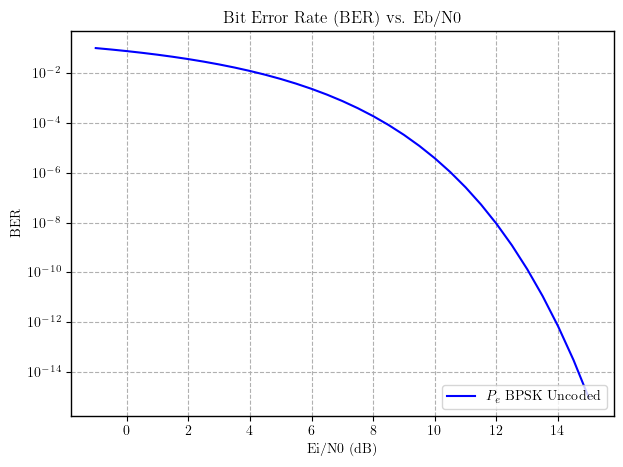

In [4]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(5e-4, 0.11)
#ax.set_ylim(1e-7, 8e-1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 4)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()

## 1.2 Código de Hamming do primeiro laboratório
---

In [5]:
# Defining a function as a Hamming coder
def hamming_coder(input_vector: np.ndarray) -> np.ndarray:
    # Defining a parity matrix
    G = np.array([[1, 0, 0, 0, 1, 1, 1],
                  [0, 1, 0, 0, 1, 0, 1],
                  [0, 0, 1, 0, 1, 1, 0],
                  [0, 0, 0, 1, 0, 1, 1]], dtype=int)
    # Encoding the input vector
    output_vector = np.dot(input_vector, G) % 2
    return output_vector

In [6]:
# Define a function for a Binary Symmetric Channel with parameter p
def bsc(input_vector: np.ndarray, p: float) -> np.ndarray:
    # Generate a random vector with the same length as the input vector
    random_vector = np.random.rand(input_vector.shape[0])
    # Apply the channel to the input vector
    output_vector = (input_vector + (random_vector < p)) % 2
    return output_vector

In [7]:
# Define a function for the syndrome calculator
def syndrome(input_vector: np.ndarray) -> np.ndarray:
    # Defining a parity-check matrix
    H = np.array([[1, 1, 1, 0, 1, 0, 0],
                  [1, 0, 1, 1, 0, 1, 0],
                  [1, 1, 0, 1, 0, 0, 1]], dtype=int)
    # Decoding the input vector
    output_vector = np.dot(input_vector, H.T) % 2
    return output_vector

In [8]:
s_dict = {
    '0': (np.array([0, 0, 0]), np.array([0, 0, 0, 0, 0, 0, 0])),
    '1': (np.array([1, 1, 1]), np.array([1, 0, 0, 0, 0, 0, 0])),
    '2': (np.array([1, 0, 1]), np.array([0, 1, 0, 0, 0, 0, 0])),
    '3': (np.array([1, 1, 0]), np.array([0, 0, 1, 0, 0, 0, 0])),
    '4': (np.array([0, 1, 1]), np.array([0, 0, 0, 1, 0, 0, 0])),
    '5': (np.array([1, 0, 0]), np.array([0, 0, 0, 0, 1, 0, 0])),
    '6': (np.array([0, 1, 0]), np.array([0, 0, 0, 0, 0, 1, 0])),
    '7': (np.array([0, 0, 1]), np.array([0, 0, 0, 0, 0, 0, 1]))
}

In [9]:
# Calculating the e_prime from syndrome
def e_prime_calc(s: np.ndarray) -> np.ndarray:
    for s_index in s_dict.items():
        if np.array_equal(s_index[1][0], s):
            return s_index[1][1]

In [10]:
# Defining the Hamming decoder function with 1-bit correction
def hamming_decoder(input_vector: np.ndarray) -> np.ndarray:
    s = syndrome(input_vector)
    e_prime = e_prime_calc(s)
    decoded = (input_vector + e_prime) % 2
    return decoded[:4]

In [11]:
def hamming_pb_est(p: float) -> float:
    sample_size = 1_000_000
    error_count = 0
    k = 4
    l = int(sample_size/k)

    for _ in range(l):
        input_vector = np.random.randint(0, 2, k)
        input_decoded = hamming_coder(input_vector)
        transmitted_vector = bsc(input_decoded, p)
        decoded_vector = hamming_decoder(transmitted_vector)
        error_count += np.count_nonzero(input_vector != decoded_vector)

    return (1/sample_size) * error_count 

In [12]:
K = 4
N = 7

R = K/N

In [13]:
hamming_pb_est(0.1)

0.06657199999999999

In [14]:
def hamming_pb_est_parallel(p: float, sample_size: int) -> float:
    error_count = 0
    k = 4

    input_vector = np.random.randint(0, 2, k)
    input_decoded = hamming_coder(input_vector)
    transmitted_vector = bsc(input_decoded, p)
    decoded_vector = hamming_decoder(transmitted_vector)
    error_count += np.count_nonzero(input_vector != decoded_vector)

    return error_count

In [15]:
# 1.5 min
def worker(args):
    prob, sample_size = args
    return hamming_pb_est_parallel(prob, sample_size)

if __name__ == "__main__":
    erros_list_hamming = []
    prob_list = [0.5, 0.2, 0.1, 0.05, 
                 0.02, 0.01, 0.005, 0.001, 
                 0.0005, 0.0004, 0.0003, 0.00025, 
                 0.0001, 0.00005, 0.00001, 0.000005, 0.00001]    

    # Create a Pool of processes
    with Pool() as p:
        for prob in prob_list:
            # Map the function to the data
            if prob >= 0.001:
                sample_size = 5_000_000
                l = int(sample_size/4)
                erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(prob, sample_size) for _ in range(l)]))))
                erros_list_hamming.append(np.sum(erros)/sample_size)
            else: 
                sample_size = 10_000_000
                l = int(sample_size/4)
                erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(prob, sample_size) for _ in range(l)]))))
                erros_list_hamming.append(np.sum(erros)/sample_size)

In [16]:
def q_inv(v: np.ndarray) -> np.ndarray:
    return np.sqrt(2) * special.erfinv(np.ones(len(v)) - np.dot(2, v))

def Ei_N0_dB_BSC_convert(prob_list: np.ndarray, R: float) -> np.ndarray:
    Eb_N0 = ((q_inv(prob_list)) ** 2) / 2
    Ei_N0 = Eb_N0 / R
    return 10 * np.log10(Ei_N0)

In [17]:
Ei_N0_from_p_hamming = Ei_N0_dB_BSC_convert(prob_list, R)

/tmp/ipykernel_28070/1399184551.py:7: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(Ei_N0)


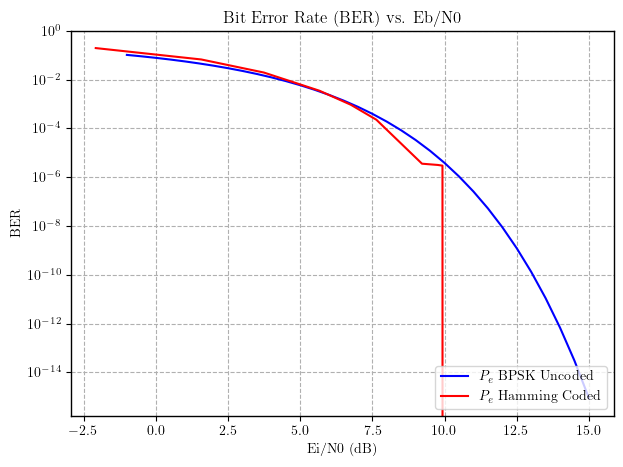

In [18]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.plot(Ei_N0_from_p_hamming, erros_list_hamming, label=r"Hamming Coded", color='red')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(0, 5)
#ax.set_ylim(1e-7, 8e-1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 4)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()

## 1.3 Desempenho do código LDPC com $N \approx 1000$ utilizando o algoritmo bit-flipping do segundo laboratório
---

In [19]:
# Define a function to set the parameters
@njit
def set_params(N: int, dv: int, dc: int) -> tuple[int, int]:
    if (N  % dc != 0):
        raise ValueError("N must be divisible by dc")
    else:
        K = int(N / dc)
        M = int(K * dv)
        return (K, M)

In [20]:
# Define a function for a Binary Symmetric Channel with parameter p
@njit
def bsc(input_vector: np.ndarray, p: float) -> np.ndarray:
    # Generate a random vector with the same length as the input vector
    random_vector = np.random.rand(input_vector.shape[0])
    # Apply the channel to the input vector
    output_vector = (input_vector + (random_vector < p)) % 2
    return output_vector

In [21]:
def is_peg_matrix(matrix: np.ndarray) -> bool:
    """
    Checa se uma matriz é uma matriz PEG (Progressive Edge Growth).

    Parâmetros:
    - matrix (ndarray): A matriz a ser verificada.

    Retorna:
    - bool: True se a matriz é uma matriz PEG, False caso contrário.
    """
    # Check if the matrix is binary
    if not np.array_equal(matrix, matrix.astype(bool)):
        return False

    # Check if the matrix is sparse
    if np.count_nonzero(matrix) / matrix.size > 0.5:
        return False

    # Check if the matrix is regular
    row_counts = np.count_nonzero(matrix, axis=1)
    if np.any(row_counts != row_counts[0]):
        return False
    col_counts = np.count_nonzero(matrix, axis=0)
    if np.any(col_counts != col_counts[0]):
        return False

    return True

def generate_LDPC_matrix_PEG(N: int, dv: int, dc: int, K: int, M: int) -> np.ndarray:
    """
    Gera uma matriz LDPC usando o algoritmo PEG (Progressive Edge Growth).

    Parâmetros:
    - N (int): O número total de colunas da matriz.
    - dv (int): O grau do vértice variável.
    - dc (int): O grau do vértice de checagem.
    - K (int): O número de linhas da matriz antes da expansão.
    - M (int): O número de vezes que a matriz é expandida.

    Retorna:
    - H (ndarray): A matriz LDPC gerada.
    """
    H = np.zeros((M, N), dtype=np.int32)
    check_degrees = np.zeros(M, dtype=np.int32)
    symbol_degrees = np.zeros(N, dtype=np.int32)
    edges = []

    for j in range(N):
        for k in range(dv):
            if k == 0:
                min_degree = np.min(check_degrees)
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1
            else:
                tree = [j]
                for l in range(1, dc + 1):
                    next_level = []
                    for node in tree:
                        next_level.extend([edge[1] for edge in edges if edge[0] == node])
                    if len(next_level) == 0 or len(set(next_level)) < M:
                        break
                    tree = next_level

                # Exclude nodes that are already connected to j
                connected_nodes = [edge[0] for edge in edges if edge[1] == j]
                candidate_nodes = np.setdiff1d(np.arange(M), np.union1d(tree, connected_nodes))

                if len(candidate_nodes) == 0:
                    # If no candidate nodes are available, skip this edge
                    continue

                min_degree = np.min(check_degrees[candidate_nodes])
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1

    for edge in edges:
        H[edge[0], edge[1]] = 1

    if is_peg_matrix(H):
        return H
    else:
        return generate_LDPC_matrix_PEG(N, dv, dc, K, M)

In [22]:
# Define a function for the parity check matrix
@njit
def parity_check(H: np.array, y: np.array) -> np.array:
    s = np.zeros(H.shape[0], dtype = np.int32)

    for i in range(len(H)):
        s[i] = np.sum(H[i] * y) % 2
    
    return s

# Define a function for the bit-flipping algorithm to decode the message
@njit
def bit_flipping(H: np.array, y: np.array, max_iter: int) -> np.array:
    iteration = 0
    x = y.copy()
    column_length = H.shape[1]
    errors = np.ones(column_length, dtype = np.int32)

    s = parity_check(H, x)

    while np.sum(s) != 0 and iteration <= max_iter:
        for i in range(column_length):
            errors[i] = np.sum(H[:, i] * s)

        for i in range(len(errors)):
            if errors[i] == np.max(errors):
                x[i] ^= 1    

        s = parity_check(H, x)
        iteration += 1

    return x

In [23]:
N = 1001
dv = 3
dc = 7
K, M = set_params(N, dv, dc)
LDPC_matrix_PEG = generate_LDPC_matrix_PEG(N, dv, dc, K, M)

In [24]:
@njit
def ham_bit_flip_pb_est(p: float, N: int) -> float:
    sample_size = 5_000_000.
    error_count = 0.
    k = N
    l = int(sample_size/k)
    num_of_bits = l * k

    for _ in range(l):
        input_vector = np.zeros(k, dtype = np.int32)        
        output_vector = bsc(input_vector, p)
        decoded_vector = bit_flipping(LDPC_matrix_PEG, output_vector, 10)
        error_count += np.count_nonzero(input_vector != decoded_vector)

    return error_count/num_of_bits

In [25]:
a = ham_bit_flip_pb_est(0.02, N)
a

0.0026604026604026606

In [26]:
@njit
def ham_bit_flip_pb_est_parallel(p: float, N: int) -> float:
    error_count = 0.
    k = N

    input_vector = np.zeros(k, dtype = np.int32)        
    output_vector = bsc(input_vector, p)
    decoded_vector = bit_flipping(LDPC_matrix_PEG, output_vector, 10)
    error_count += np.count_nonzero(input_vector != decoded_vector)

    return error_count

In [27]:
def worker(args):
    prob, N = args
    return ham_bit_flip_pb_est(prob, N)

if __name__ == "__main__":
    erros_list = []
    prob_list = [0.5, 0.2, 0.1, 0.05, 
                 0.02, 0.01, 0.005, 0.001, 
                 0.0005, 0.0004, 0.0003, 0.00025, 
                 0.0001, 0.00005, 0.00001, 0.000005, 0.00001]
    #sample_size = 100_000
    #l = int(sample_size/4)
    #num_of_bits = l * N

    # Create a Pool of processes
    with Pool() as p:
        #for prob in prob_list:
            # Map the function to the data
            erros_list_bit_flip = np.array(p.map(worker, [(prob, N) for prob in prob_list]))
            #erros_list.append(np.sum(erros)/num_of_bits)

In [28]:
a, erros

(0.0026604026604026606, array([], dtype=float64))

In [29]:
Ei_N0_from_p_bit_flip = Ei_N0_dB_BSC_convert(prob_list, R)

/tmp/ipykernel_28070/1399184551.py:7: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(Ei_N0)


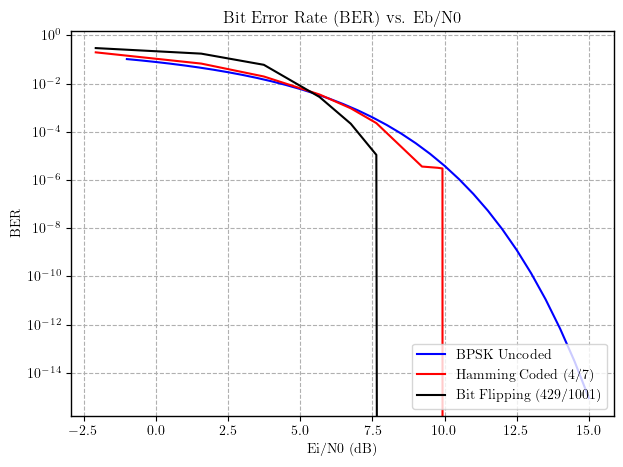

In [33]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.plot(Ei_N0_from_p_hamming, erros_list_hamming, label=r"Hamming Coded (4/7)", color='red')
ax.plot(Ei_N0_from_p_bit_flip, erros_list_bit_flip, label=r"Bit Flipping (429/1001)", color='black')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(0, 5)
#ax.set_ylim(1e-7, 8e-1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 4)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()